In [6]:
import pandas as pd
import numpy as np
from timeit import default_timer as timer
pd.options.plotting.backend = 'plotly'

In [7]:
train = pd.read_csv('train.csv')
states = train['Province_State'].unique()
state_dfs_raw = {state: train[train['Province_State'] == state] for state in states}
state_means = {}
state_stds = {}
state_dfs = {}
for s, state_df_raw in state_dfs_raw.items():
    state_df = state_df_raw.drop(columns=['Province_State', 'ID'])
    state_df['Date'] = pd.to_datetime(state_df['Date'], format='%m-%d-%Y')
    state_df = state_df.set_index('Date')

    mean, std = state_df.mean(), state_df.std()
    state_df = (state_df - mean) / std

    state_means[s] = mean
    state_stds[s] = std
    state_dfs[s] = state_df

column_names = state_dfs['Alabama'].columns

In [8]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# input is (n_samples, lag_order, n_features)
# output is (n_samples, n_features)

lag_order = 28
n_features = column_names.size

optimizer = Adam(clipnorm=1)

def model_factory():
    model = Sequential()
    model.add(LSTM(50, activation='sigmoid', input_shape=(lag_order, n_features)))
    model.add(Dense(n_features))
    model.compile(optimizer=optimizer, loss='mse')

    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=500, verbose=0, mode='min', restore_best_weights=True)

tmp_path = 'tmp/tmp_model.h5'
checkpoint = ModelCheckpoint(
        tmp_path,
        monitor='val_loss',
        verbose=0,
        save_best_only=True,
        save_weights_only=False,
        mode='min',
    )

In [9]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [10]:
# Normally takes 80s to train
models = {}
model_histories = {}
model_test_data = {}
for state in states:
    stime = timer()
    print(f'------------------------\nTraining model for {state}')
    state_data = state_dfs[state].values

    X_windows = (
        np.expand_dims(np.arange(lag_order), 0) +
        np.expand_dims(np.arange(state_data.shape[0] - lag_order), 0).T
    )
    y_indices = np.arange(lag_order, state_data.shape[0])

    X = np.nan_to_num(state_data[X_windows])
    y = np.nan_to_num(state_data[y_indices])

    split = int(X.shape[0] * 0.8)

    X_train, y_train = X[:split], y[:split]
    X_test, y_test = X[split:], y[split:]
    model_test_data[state] = (X_test, y_test)

    model = model_factory()
    model_histories[state] = model.fit(
        X_train,
        y_train,
        epochs=5000,
        verbose=0,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping]
    )
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    print(f'\tTest loss for {state}: {np.average(MSE(y_train, y_pred_train)):.4f}')
    print(f'\tValidation loss for {state}: {np.average(MSE(y_test, y_pred_test)):.4f}\n')
    models[state] = model

    print(f'\tTraining took {timer() - stime:.4f}s')


Training model for Alabama
	Test loss for Alabama: 0.012365695089101791
	Validation loss for Alabama: 0.11777332425117493

	Training took 67.75s

Training model for Alaska
	Test loss for Alaska: 0.0025464575737714767
	Validation loss for Alaska: 0.10126441717147827

	Training took 89.62s

Training model for Arizona
	Test loss for Arizona: 0.004516515880823135
	Validation loss for Arizona: 0.07461479306221008

	Training took 40.40s

Training model for Arkansas
	Test loss for Arkansas: 0.002112842630594969
	Validation loss for Arkansas: 0.1795935481786728

	Training took 81.72s

Training model for California
	Test loss for California: 8.232858817791566e-05
	Validation loss for California: 0.017152059823274612

	Training took 128.55s

Training model for Colorado
	Test loss for Colorado: 0.0006763404817320406
	Validation loss for Colorado: 0.23491992056369781

	Training took 90.17s

Training model for Connecticut
	Test loss for Connecticut: 0.006211379077285528
	Validation loss for Connec

In [11]:
def save_models():
    for state, model in models.items():
        model.save(f'models/{state}')

def load_models():
    global models
    models = {}
    for state in states:
        print(f'Loading {state} model...')
        models[state] = load_model(f'models/{state}')

In [12]:
def forecast(model, data, steps, columns, index):
    output = []
    for _ in range(steps):
        prediction = model.predict(np.reshape(data, (1, lag_order, n_features)))[0]
        output.append(prediction)
        data = np.vstack((data[1:], prediction))
    return pd.DataFrame(output, columns=columns, index=index)

In [15]:
state_forecasts = {}
periods = 26
columns, index = column_names, pd.date_range(state_dfs['Alabama'].index[-1], periods=periods + 1)[1:]
for state in states:
    print(f'Forecasting {state}...')
    data_df = state_dfs[state].iloc[-lag_order:]

    forecast_df = forecast(models[state], np.nan_to_num(data_df.values), periods, columns, index)
    state_forecasts[state] = forecast_df

Forecasting Alabama...
Forecasting Alaska...
Forecasting Arizona...
Forecasting Arkansas...
Forecasting California...
Forecasting Colorado...
Forecasting Connecticut...
Forecasting Delaware...
Forecasting Florida...
Forecasting Georgia...
Forecasting Hawaii...
Forecasting Idaho...
Forecasting Illinois...
Forecasting Indiana...
Forecasting Iowa...
Forecasting Kansas...
Forecasting Kentucky...
Forecasting Louisiana...
Forecasting Maine...
Forecasting Maryland...
Forecasting Massachusetts...
Forecasting Michigan...
Forecasting Minnesota...
Forecasting Mississippi...
Forecasting Missouri...
Forecasting Montana...
Forecasting Nebraska...
Forecasting Nevada...
Forecasting New Hampshire...
Forecasting New Jersey...
Forecasting New Mexico...
Forecasting New York...
Forecasting North Carolina...
Forecasting North Dakota...
Forecasting Ohio...
Forecasting Oklahoma...
Forecasting Oregon...
Forecasting Pennsylvania...
Forecasting Rhode Island...
Forecasting South Carolina...
Forecasting South Dako

In [19]:
cleaned_dfs = {}
for state in states:
    cleaned_df = state_forecasts[state][['Confirmed', 'Deaths']]
    cleaned_df['Province_State'] = state
    cleaned_df['Date'] = cleaned_df.index

    cleaned_df['Confirmed'] *= state_stds[state]['Confirmed']
    cleaned_df['Deaths'] *= state_stds[state]['Deaths']
    cleaned_df['Confirmed'] += state_means[state]['Confirmed']
    cleaned_df['Deaths'] += state_means[state]['Deaths']


    cleaned_dfs[state] = cleaned_df[['Province_State', 'Date', 'Confirmed', 'Deaths']]

kaggle_res = []

for _ in range(periods):
    for state in states:
        kaggle_res.append(state_forecasts[state].iloc[_])

In [24]:
state_dfs['Alabama']

,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate
Date,,,,,,,,,,
2020-04-12,-1.081612,-1.451163,NaN,-0.977881,-1.081171,-1.337257,-0.972641,-0.180803,-1.340628,0.630798
2020-04-13,-1.077266,-1.441323,NaN,-0.970797,-1.076618,-1.311068,-0.968219,-0.132734,-1.313159,0.617707
2020-04-14,-1.071698,-1.416721,NaN,-0.962039,-1.070786,-1.297506,-0.960259,0.138927,-1.298934,0.734577
2020-04-15,-1.068597,-1.410161,NaN,-0.956972,-1.067537,-1.294197,-0.953184,0.152733,-1.295464,0.941486
2020-04-16,-1.061734,-1.385559,NaN,-0.946025,-1.060347,-1.286222,-0.946994,0.345796,-1.287100,0.863040
...,...,...,...,...,...,...,...,...,...,...
2020-08-27,1.904284,1.801151,1.689791,1.917901,1.905858,1.885961,2.027223,-1.225969,1.888886,0.282799
2020-08-28,1.933822,1.851994,1.689791,1.966458,1.935449,1.913718,NaN,-1.215389,1.916728,NaN
2020-08-29,1.977139,1.925798,1.689791,2.037684,1.978842,1.951474,NaN,-1.200666,1.954597,NaN


In [29]:
data[:, 0]

array([1.20976923, 1.23396958, 1.28323458, 1.32667828, 1.37426552,
       1.40377876, 1.44663779, 1.46776225, 1.49153045, 1.51112969,
       1.53024593, 1.56255543, 1.58423915, 1.59875428, 1.63324994,
       1.66164468, 1.68632802, 1.71640052, 1.739279  , 1.75270104,
       1.79464493, 1.80816865, 1.85931477, 1.9042837 , 1.93382237,
       1.97713896, 2.011355  , 2.0322761 ])

In [27]:
data = state_dfs['Alabama'].iloc[-lag_order:].values
models['Alabama'].predict(np.nan_to_num(np.reshape(data, (1, lag_order, n_features))))[0]

array([ 1.5459776 ,  1.4284569 ,  1.3000047 ,  1.6606361 ,  1.4750081 ,
        1.3294761 ,  1.6293648 , -1.1350497 ,  1.3542941 ,  0.29056415],
      dtype=float32)

In [22]:
state_forecasts['Alabama']

,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate
2020-09-01,1.545978,1.428457,1.300005,1.660636,1.475008,1.329476,1.629365,-1.135050,1.354294,0.290564
2020-09-02,1.529409,1.395775,1.159419,1.600042,1.425157,1.285831,1.604101,-1.181757,1.305734,0.398073
2020-09-03,1.515352,1.379551,1.110125,1.575978,1.412603,1.270509,1.587449,-1.185464,1.284562,0.419728
2020-09-04,1.506998,1.370971,1.090348,1.565647,1.406418,1.263194,1.579183,-1.185745,1.274860,0.422868
2020-09-05,1.501225,1.365778,1.080485,1.560708,1.403568,1.258577,1.574807,-1.185670,1.269116,0.421583
2020-09-06,1.496923,1.362103,1.074200,1.557897,1.402278,1.255000,1.572203,-1.185728,1.265065,0.419371
2020-09-07,1.493467,1.359180,1.069357,1.555997,1.401746,1.251883,1.570452,-1.185946,1.261844,0.417080
2020-09-08,1.490548,1.356690,1.065216,1.554511,1.401580,1.249043,1.569138,-1.186277,1.259104,0.414909
2020-09-09,1.487999,1.354481,1.061507,1.553245,1.401599,1.246417,1.568087,-1.186670,1.256690,0.412887
2020-09-10,1.485728,1.352485,1.058125,1.552078,1.401680,1.243997,1.567193,-1.187078,1.254531,0.411013


In [21]:
state_dfs_raw['Alabama']['Confirmed'].plot()

In [20]:
cleaned_dfs['Alabama']['Confirmed'].plot()

<AxesSubplot:>

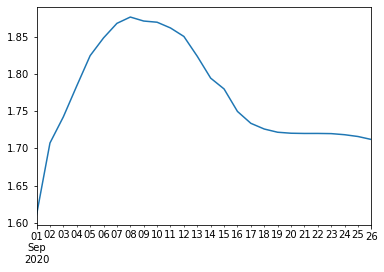

In [173]:
state_forecasts['Alabama']['Deaths'].plot()

In [169]:
state_dfs_raw['Alabama']['Confirmed']

0         3563
50        3734
100       3953
150       4075
200       4345
         ...  
6850    121023
6900    122185
6950    123889
7000    125235
7050    126058
Name: Confirmed, Length: 142, dtype: int64

<AxesSubplot:>

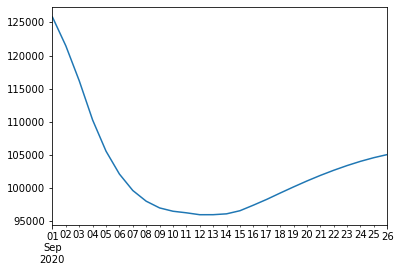

In [168]:
cleaned_dfs['Alabama']['Confirmed'].plot() # state_stds['Alabama']['Confirmed']